# Прогнозирование оттока клиентов "Теледом"

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

**Файл `contract_new.csv`**
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv`**
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv`**
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv`**
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

In [1]:
import sklearn # Проверка версии sklearn. Обновляем при необходимости
if sklearn.__version__[0] == '0':
    !pip install scikit-learn==1.5.1 # После установки надо перезапустить ядро
sklearn.__version__ 

'1.5.1'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

try:
    from ydata_profiling import ProfileReport
except:
    !pip install -U Pillow # Для решения ошибки с профайлером
    !pip install -U ydata-profiling
    from ydata_profiling import ProfileReport

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [22]:
RANDOM_STATE=20924

## Загрузка, предварительный анализ и предобработка данных

Начнём с загрузки и отдельного представления каждого датасета. Всего их у нас четыре штуки, и чтобы не дублировать конструкции try-except, нужные нам для работы проекта и на сервере и на локальной машине, загрузку будем проводить при помощи функции.

In [4]:
def load(path, dates=None):
    try:
        data = pd.read_csv(path, parse_dates=dates, index_col='customerID')
    except:
        data = pd.read_csv('/'+path, parse_dates=dates, index_col='customerID')
    return data

Начнём с данных о контрактах. Айди клиента - первичный ключ, который имеется у всех наших таблиц, и его мы сразу переведём в индексы.

In [5]:
contract = load('datasets/contract_new.csv', [1])
ProfileReport(contract)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

И так, сразу обратим внимание на наш целевой признак - `EndDate`. Его ещё надо немного преобразовать и выделить в отдельный столбец, но в общем и целом, если значение в нём не равно `no` - значит клиент расторгнул контракт. Это нам и надо научиться угадывать. 

Сами по себе даты не слишком информативны для моделей, однако из них можно будет выделить новый признак - количество дней, в течение которых контракт был активен. 

У `MonthlyCharges` присутствует большое количество экстремально малых значений, но они распределены около значения 20, и их нельзя назвать аномалией. Можно предположить, что где-то там и находится стоимость оказания минимального количества услуг, и многим клиентам нужен только самый минимум.

`TotalCharges` сохранился как текст. К этому мы ещё вернёмся.

Также в данных имеются дубликаты, что вполне возможно, учитывая, что уникальный идентификатор клиента в анализе не учитывался. Не будем обращать на них внимания.

Сразу-же займёмся признаком `TotalCharges`. Что-то препятствует определению его как числового. Найдём, в чём именно проблема. Для этого попробуем выполнить заведемо ошибочную операцию, приготовившись ловить название ошибки.

In [6]:
try:
    pd.to_numeric(contract['TotalCharges'])
except Exception as e:
    print(e)

Unable to parse string " " at position 488


А вот и аномалия. Пробел в 488 строке, хотя их может быть и больше. Заменим пробелы на пропуски и переведем столбец в числовой тип.

In [7]:
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = np.nan
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
contract['TotalCharges'].dtypes

dtype('float64')

Теперь мы сможем посмотреть на распределение значений.

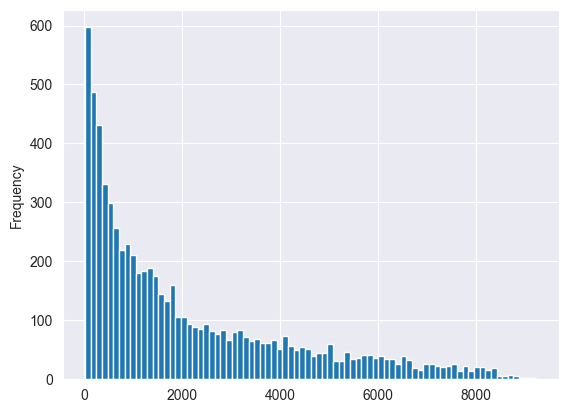

In [8]:
contract['TotalCharges'].plot(kind='hist', bins=80);

Распределение крайне сильно смещено влево, но похоже на правдивое. Далеко не каждый клиент остаётся с компанией надолго и приносит большую прибыль.

Далее загрузим подробные данные о клиентах.

In [9]:
personal = load('datasets/personal_new.csv')
ProfileReport(personal)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Умеренная корреляция наличия партнера и детей. Звучит логично, но до линейной зависимости далеко. В остальном нет ничего, требующего нашего внимания. Данные в отличном состоянии.

Дальше - информация об интернет-услугах.

In [10]:
internet = load('datasets/internet_new.csv')
ProfileReport(internet)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Умеренная корреляция стриминга фильмов и ТВ, в остальном всё стабильно.

И последний датасет - дополнительные телефонные услуги, в котором всего один признак. Не будем его обделять и проведём полноценный EDA.

In [11]:
phone = load('datasets/phone_new.csv')
ProfileReport(phone)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ни пропусков, ни аномалий. На этом предварительный анализ можно заканчивать и переходить к объединению данных.

**Итого**: Мы провели загрузку всех четырех имеющихся датасетов, провели разведочный анализ, определили перспективы формирования новых признаков, в том числе и целевого признака, а также исправили ошибку определения типа данных столбца `TotalCharges`

## Объединение датасетов и исследовательский анализ

Объединим все датасеты воедино. Для этого используем присоединение по индексу, за основу возьмём датасет `contract` и будем присоединять датасеты один за другим.

In [14]:
ds = contract.join(personal)
ds = ds.join(internet)
ds = ds.join(phone)
ProfileReport(ds)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Возникло много ошибок, но в основном всё связано с двумя факторами - 1) Не все пользуются интернетом или телефонами, и 2) Ежемесячная оплата крайне сильно зависит от подключенных услуг. Разберёмся по порядку. 

21.7% отсутствующих значений в данных по интернету и 9.7% в данных по телефонным линиям. Судя по всему, соответствующее количество клиентов не пользуется интернетом или телефоном, поэтому в датасетах нету информации о них. Можно было-бы просто заполнить пропуски False, т.к. эти клиенты определенно не подключали дополнительных услуг, раз не пользуются даже основными. Однако давайте отдельно отметим тот факт, что они не пользуются основными сервисами.

In [21]:
ds['InternetService'] = ds['InternetService'].fillna('Offline')
for i in internet.columns:
    ds[i] = ds[i].fillna('No')
    print(ds[i].unique())

['DSL' 'Fiber optic' 'Offline']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


То-же самое проделаем для данных о телефонах

In [23]:
ds['MultipleLines'] = ds['MultipleLines'].fillna('Offline')
ds['MultipleLines'].unique()

array(['Offline', 'No', 'Yes'], dtype=object)

Теперь вернёмся к зависимости ежемесячной оплаты. Самая высокая корреляция у неё с типом подключения интернета, проверим так-ли страшна корреляция, как о ней говорят. Заодно, раз-уж мы уже выделили сегмент клиентов, не пользующихся интернетом, отдельно посмотрим и на них.

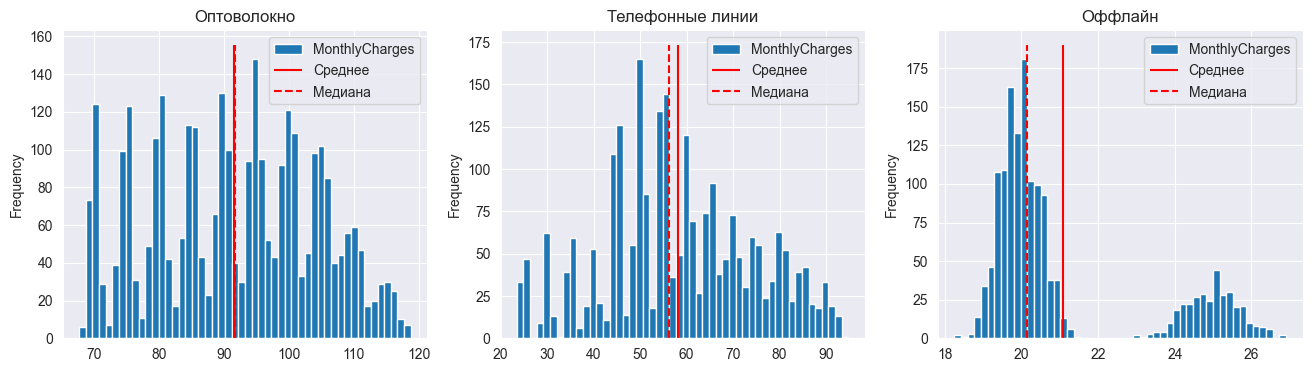

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i in [['Fiber optic','Оптоволокно', 0], ['DSL','Телефонные линии', 1], ['Offline', 'Оффлайн', 2]]:
    ds.loc[ds['InternetService']==i[0], 'MonthlyCharges'].plot(kind='hist', ax=axes[i[2]], title=i[1], bins=50)
    ymin, ymax = axes[i[2]].get_ylim()
    axes[i[2]].vlines(x=ds.loc[ds['InternetService']==i[0], 'MonthlyCharges'].mean(), colors='red', ymin=ymin, ymax=ymax, label='Среднее')
    axes[i[2]].vlines(x=ds.loc[ds['InternetService']==i[0], 'MonthlyCharges'].median(), colors='red', ymin=ymin, ymax=ymax, linestyles='--', label='Медиана')
    axes[i[2]].legend()

Разница разительная. Оптоволокно почти гарантирует высокую абонентскую плату, плата за интернет по телефонным линиям растёт более равномерно, а оффлайн-сегмент как раз и платит за тот самый минимум услуг. Хотя корреляция и высокая, линейной зависимости тут нет. Два одинаковых по абонетской плате клиента могут быть подключены к интернету разными способами. Оставим признак до лучших времён.

Однако до модели мы допустим не все признаки. Например, столбец `gender` никак не соотносится ни с какими другими признаками, поэтому с ним мы попрощаемся.

In [53]:
ds = ds.drop('gender', axis=1)
ds.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')

Прежде чем переходить к подготовке данных, выделим целевой признак. Напомню, им у нас является наличие даты в столбце `EndDate`

In [58]:
ds['Terminated'] = ds['EndDate'] != 'No'
ds['Terminated'].value_counts()

Terminated
False    5942
True     1101
Name: count, dtype: int64

Готово. 1 - значит, договор расторгнут, 0 - всё ещё действует на момент выгрузки данных.

**Итого**: Мы провели объединение датасетов, выделили сегменты пользователей, не пользующихся интернетом или телефоном, провели проверку корреляции ежемесячной абонентской платы от типа подключения интернета, избавились от неинформативного признака `gender` и выделили целевой признак `Terminated`.

## Подготовка данных

Вместо того, чтобы вручную преобразовывать признаки, мы поступим хитрее. Создадим класс, который будет принимать данные в изначальном виде(насколько это возможно), и возвращать их преобразованные и готовые. Класс сделаем на основе трансформера sklearn, так его можно будет применять в пайплайне.

In [ ]:
class DateFeatures(TransformerMixin, BaseEstimator): # Класс для преобразования признаков в пайплайне
    def __init__(self): 
        self.isittest = False
    
    def fit(self, X, y): # Обучение классу не требуется, скипаем
        self.isittest = False
        return self
    
    def transform(self, X):
        dc = X.copy()
        # Тут какая-то срань, типа обработка, потом сделаю
        self.isittest = True
        return dc